In [2]:
import xarray as xr
import numpy as np
import pandas as pd

import datetime
from scipy import stats
from scipy import signal

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm

#각종 상수
path = '../../Data/1degree/'
npp_u = r'mg C m$^{-2}$ day$^{-1}$'
sst_u = '°C'
start_date, end_date = (np.datetime64('2003-01-01'), np.datetime64('2022-12-01'))
latitude_range = (18, 22)  # 18-22N
longitude_range = (126, 131)  # 126-131E

# 사용한 데이터
- NPP : [MODIS Based standard VGPM](http://orca.science.oregonstate.edu/1080.by.2160.monthly.hdf.vgpm.m.chl.m.sst.php)

- SST : [NOAA OI SST](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html)

- nino3.4 : [NOAA, Calculated from the OISST.v2.1](https://www.cpc.ncep.noaa.gov/data/indices/)

- time interval : Monthly
- All grid data are interpolated to a 1x1 degree grid, climatology is substituted, and the data are transformed into a detrended anomalous form.

### Execute

노란 점선은 각각 2020.09.01. , 2022.09.01 입니다.

### codes

In [10]:

def g_regression(x, y):
    """
    Calculate linear regression between x and y which contains nan.
    
    Args:
    x (xarray.DataArray): dataarray (time, lat, lon).
    y (xarray.DataArray): dataarray (time, lat, lon).
    x and y shape must be same.
    
    Returns:
    tuple: Two 2D numpy arrays containing the slopes, R-squared values and P-values respectively.
    """
    s = x.data.shape  # (time, lat, lon)
    s_y = y.data.shape
    
    # Initialize slope and r-squared arrays
    p_shape = (s[1], s[2])
    slopes = np.zeros(p_shape)
    r_squared = np.zeros(p_shape)
    p_values = np.zeros(p_shape)
    
    if s != s_y : return slopes, r_squared, p_values
    
    m_x = x.to_masked_array()
    m_y = y.to_masked_array()

    not_nan_indices = ~np.logical_or(m_x.mask, m_y.mask)
    valid_count = np.sum(not_nan_indices, axis=0)

    # Iterate over latitudes and longitudes
    for lat in range(s[1]):
        for lon in range(s[2]):
            x = m_x[:, lat, lon]
            y = m_y[:, lat, lon]
            not_nan_ind = not_nan_indices[:, lat, lon]
            if valid_count[lat, lon] < s[0] // 10:
                slope, r, p = np.nan, np.nan, np.nan
            else:
                slope, _, r, p, _ = stats.linregress(x[not_nan_ind], y[not_nan_ind])
            slopes[lat, lon], r_squared[lat, lon], p_values[lat,lon] = slope, r**2, p

    return slopes, r_squared, p_values

def drawcontourf(sst, slope, rs, cline=True, title='', barname='', slevels=[], rslevels=[], figsize = None, norm=None, g= False):
    line_color = 'black'
    #각 글로벌 스케일 일때 아닐때 폰트 사이즈
    title_font_size = 20 if g else 12 #제목
    lable_font_size = 14 if g else 10 #라벨
    tick_font_size = 14 if g else 10 #틱(컬러바 숫자표시하는거)
    
    lon = sst.lon.data
    lat = sst.lat.data
    x, y = np.meshgrid(lon,lat)
    s = np.ma.masked_invalid(slope)
    rs = np.ma.masked_invalid(rs)
    
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=180.0))
    ax.add_feature(cfeature.COASTLINE, color='gray')
    if len(slevels) > 0:
        filled_c = ax.contourf(x, y, s, slevels, transform=ccrs.PlateCarree(), transform_first = True, cmap='coolwarm', norm=norm, extend = 'both')
    else : filled_c = ax.contourf(x, y, s, transform=ccrs.PlateCarree(), transform_first = True, cmap='coolwarm', norm=norm, extend = 'both')
    
    if cline:
        if len(rslevels) : 
            line_c = ax.contour(x, y, rs, rslevels, colors=[line_color],linewidths=0.5, transform=ccrs.PlateCarree(), transform_first=True)
        else : line_c = ax.contour(x, y, rs, colors=[line_color], linewidths=0.5, transform=ccrs.PlateCarree(), transform_first=True)
        
        ax.clabel(
        line_c,  # Typically best results when labelling line contours.
        colors=[line_color],
        manual=False,  # Automatic placement vs manual placement.
        inline=True,  # Cut the line where the label will be placed.
        fmt=' {:.2f} '.format,  # Labes as integers, with some extra space.
        )
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': lable_font_size}
    gl.ylabel_style = {'size': lable_font_size}
    gl.right_labels = False
    
    #글로벌 그래프라면 해당 영역을 추가해보자?
    if g:
        # 사각형을 정의하는 꼭지점 좌표 설정 (남서쪽 꼭지점과 가로/세로 길이)
        southwest_corner = (126, 18)  # 18N, 126E
        width = 131 - 126  # 경도 차이
        height = 22 - 18   # 위도 차이
        # Rectangle 객체 생성
        rectangle = Rectangle(southwest_corner, width, height, 
                            transform=ccrs.PlateCarree(),
                            fill=False,  # 내부를 채우지 않음
                            edgecolor='black', linewidth=2)  # 경계선 색상과 두께 설정
        # 사각형을 지도에 추가
        ax.add_patch(rectangle)
    
    ax_pos = ax.get_position()
    cbar_ax = fig.add_axes([ax_pos.x1 + 0.01, ax_pos.y0, 0.02, ax_pos.height])
    cbar = plt.colorbar(filled_c, cax=cbar_ax)
    
    cbar.set_label(barname, fontsize = lable_font_size)
    cbar.ax.tick_params(labelsize=tick_font_size)
    
    
    ax.set_title(title, fontsize =title_font_size, pad= 20)
        
    plt.show()

def srange(arr):
    return f'{np.nanmin(arr):.3f} to {np.nanmax(arr):.3f}'

def printranges(ss,rss):
    for i in range(len(ss)):
        print(f's : {srange(ss[i])}, rs : {srange(rss[i])}')

def getSlevels(max_val, step, scale = 1):
    slevels = np.append(np.arange(-1*max_val,0,step=step),np.arange(0,max_val+step,step=step))*scale
    # slevels = np.linspace(-1*max_val, max_val, num=num)*scale
    # slevels = np.linspace(-1*max_val, max_val, num=num)*scale
    norm = TwoSlopeNorm(vmin=max_val*-1*scale, vcenter=0, vmax=max_val*scale)
    
    return slevels, norm

reg_unit = f'{npp_u}/{sst_u}'

In [59]:
l_npp= xr.open_dataarray(f'{path}d_l_nppa.nc').squeeze()
l_5m_npp= xr.open_dataset(f'{path}d_l_5m_running_nppa.nc')['vgpm'].squeeze()
l_5y_npp= xr.open_dataset(f'{path}d_l_5y_running_nppa.nc')['vgpm'].squeeze()

m_start, m_end = l_5m_npp.date.min().values,l_5m_npp.date.max().values
y_start, y_end = l_5y_npp.date.min().values,l_5y_npp.date.max().values

#global SSTA and NPPA
g_5m_sst = xr.open_dataset(f'{path}d_5m_running_ssta.nc')['sst'].sel(lat=slice(-65,75),time=slice(m_start,m_end)).rename({'time':'date'})
g_5y_sst = xr.open_dataset(f'{path}d_5y_running_ssta.nc')['sst'].sel(lat=slice(-65,75),time=slice(y_start,y_end)).rename({'time':'date'})
g_5m_npp = xr.open_dataset(f'{path}d_5m_running_nppa.nc')['vgpm'].sel(lat=slice(-65,75))
g_5y_npp = xr.open_dataset(f'{path}d_5y_running_nppa.nc')['vgpm'].sel(lat=slice(-65,75))

#local SSTA and NPPA
t_5m_sst = g_5m_sst.sel(lat=slice(18,22), lon=slice(126,131))
t_5y_sst = g_5y_sst.sel(lat=slice(18,22), lon=slice(126,131))
t_5m_npp = g_5m_npp.sel(lat=slice(18,22), lon=slice(126,131))
t_5y_npp = g_5y_npp.sel(lat=slice(18,22), lon=slice(126,131))

In [44]:
g_5m_npp

<xarray.DataArray 'vgpm' (date: 249, lat: 141, lon: 360)> Size: 101MB
[12639240 values with dtype=float64]
Coordinates:
  * date     (date) datetime64[ns] 2kB 2002-09-01 2002-10-01 ... 2023-05-01
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float64 1kB -65.0 -64.0 -63.0 -62.0 ... 72.0 73.0 74.0 75.0
Attributes: (12/20)
    Central_Azimuth:      0
    Hole Value:           -9999
    Intercept:            0
    Isotropic:            0
    Latitude Center:      0
    Limit:                -90, -180, 90, 180
    ...                   ...
    Source:               not specified
    Start Time:           1094022000
    Start Time String:    09/01/2004 00:00:00
    Stop Time:            1096613999
    Stop Time String:     09/30/2004 23:59:59
    Units:                mgC m-2 day-1

In [60]:
ss = []
rss = []
ps = []

reg_pairs = [(t_5m_sst, t_5m_npp, 'grid'), (g_5m_sst, l_5m_npp, 'line'),(t_5y_sst, t_5y_npp, 'grid'), (g_5y_sst, l_5y_npp, 'line')]
# reg_pairs_5y = [(t_5y_sst, t_5y_npp, 'grid'), (g_5y_sst, l_5y_npp, 'line')]
titles = ['Regression NPPA on SSTA', 'Global map of field averaged NPPA on SSTA by coordinates']
ss, rss, ps = zip(*[g_regression(x,y) if m=='grid' else g_regression(x,y.broadcast_like(x)) for x,y, m in reg_pairs])
ss1, rss1, ps1 = zip(*[g_regression(y,x) if m=='grid' else g_regression(y.broadcast_like(x),x) for x,y, m in reg_pairs])

In [57]:
printranges(ss, rss)

s : -31.903 to -22.918, rs : 0.134 to 0.367
s : -33.721 to 22.716, rs : 0.000 to 0.337
s : -40.057 to -6.073, rs : 0.018 to 0.442
s : -135.188 to 116.543, rs : 0.000 to 0.901


/opt/homebrew/Caskroom/miniforge/base/envs/oparcels/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


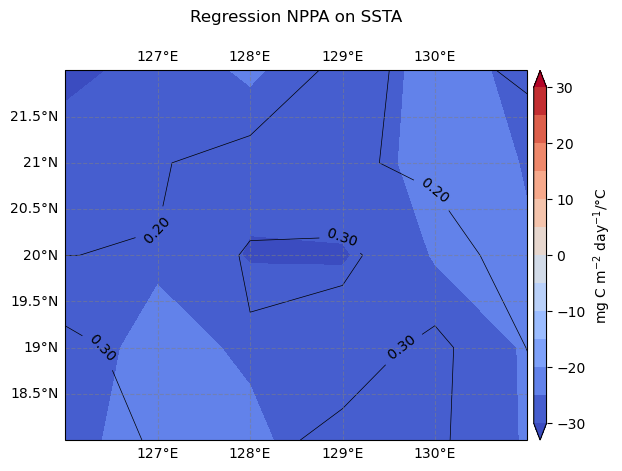

/opt/homebrew/Caskroom/miniforge/base/envs/oparcels/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/homebrew/Caskroom/miniforge/base/envs/oparcels/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


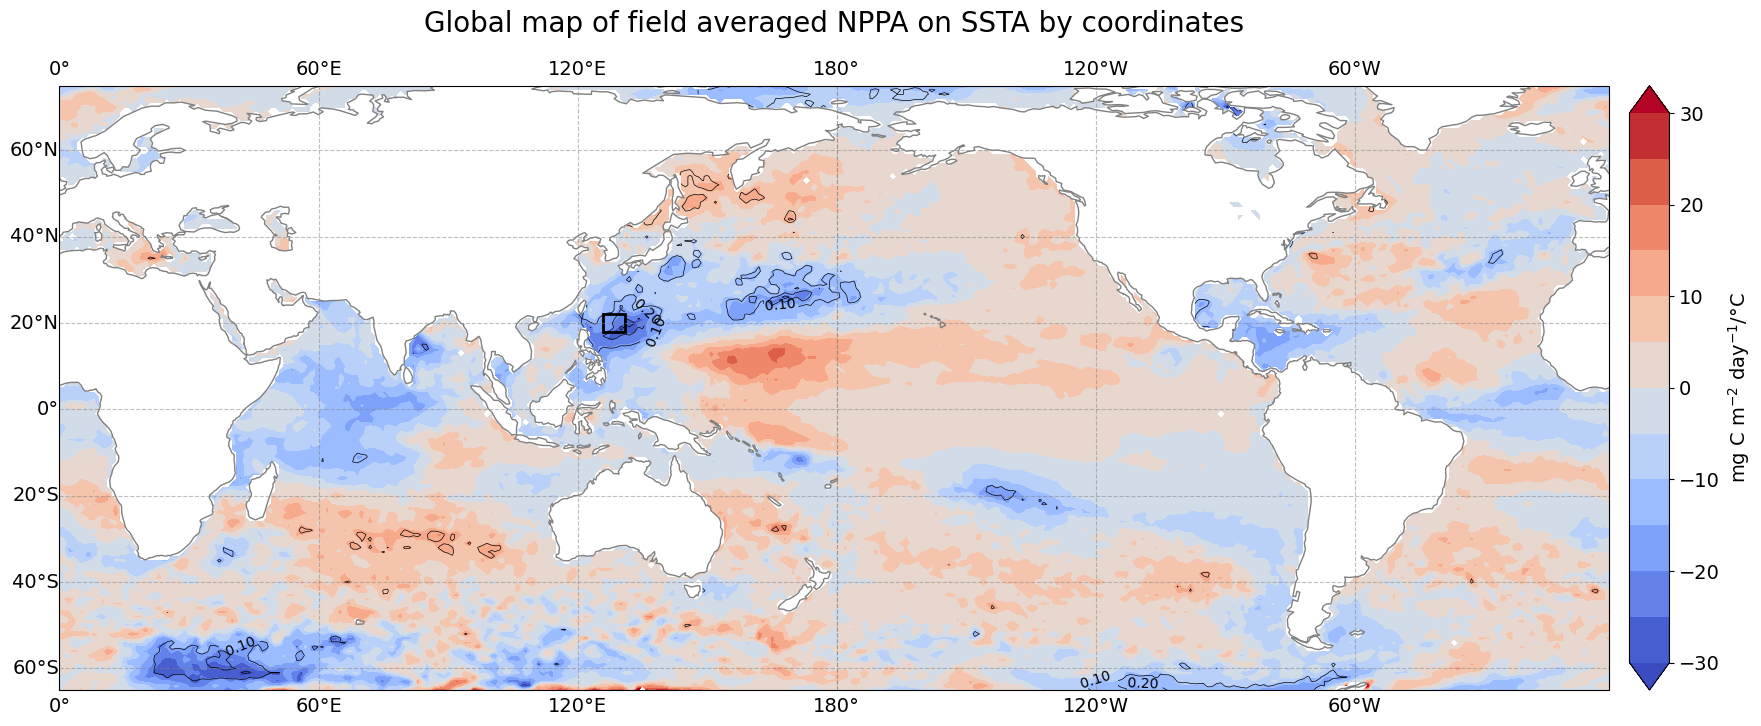

In [48]:
scale=1
slevels, norm = getSlevels(30, step=5,scale=scale)
rslevels = np.arange(0.0, 0.9, 0.1)

drawcontourf(reg_pairs[0][0], ss[0]*scale, rss[0], cline=True, title=titles[0], barname=f'{reg_unit}', slevels=slevels, rslevels=rslevels, norm=norm)
drawcontourf(reg_pairs[1][0], ss[1]*scale, rss[1], cline=True, title=titles[1], barname=f'{reg_unit}', figsize=(20,13), slevels=slevels, rslevels=rslevels, norm=norm, g=True)

/opt/homebrew/Caskroom/miniforge/base/envs/oparcels/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


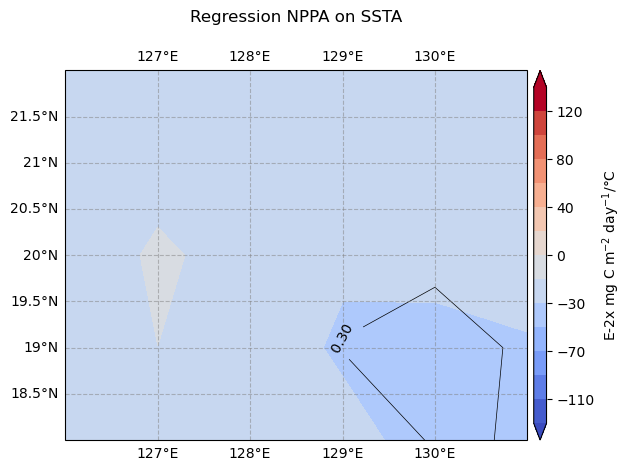

/opt/homebrew/Caskroom/miniforge/base/envs/oparcels/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/homebrew/Caskroom/miniforge/base/envs/oparcels/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


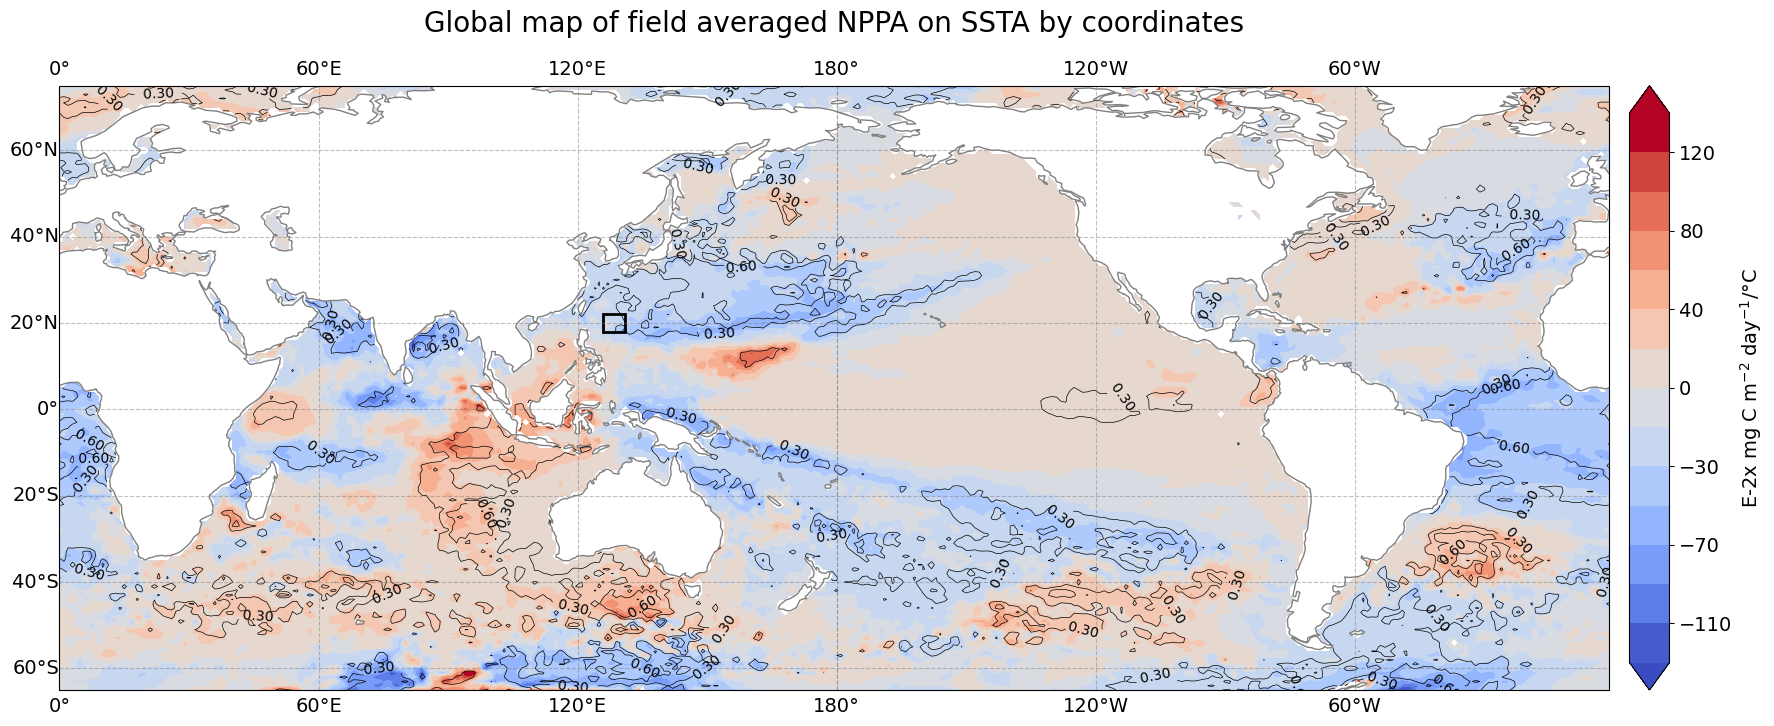

In [61]:
scale=1
slevels, norm = getSlevels(130, step=20,scale=scale)
# rslevels = np.arange(0.0, 0.9, 0.1)
rslevels = np.arange(0.0, 0.9, 0.3)

drawcontourf(reg_pairs[2][0], ss[2]*scale, rss[2], cline=True, title=titles[0], barname=f'E-2x {reg_unit}', slevels=slevels, rslevels=rslevels, norm=norm)
drawcontourf(reg_pairs[3][0], ss[3]*scale, rss[3], cline=True, title=titles[1], barname=f'E-2x {reg_unit}', figsize=(20,13), slevels=slevels, rslevels=rslevels, norm=norm, g=True)

In [11]:
def g_regression(x, y):
    s = x.data.shape  # (time, lat, lon)
    m_x = x.to_masked_array()
    m_y = y.to_masked_array()

    not_nan_indices = ~np.logical_or(m_x.mask, m_y.mask)
    valid_count = np.sum(not_nan_indices, axis=0)

    # Initialize slope and r-squared arrays
    p_shape = (s[1], s[2])
    slopes = np.zeros(p_shape)
    r_squared = np.zeros(p_shape)
    p_values = np.zeros(p_shape)

    # Iterate over latitudes and longitudes
    for lat in range(s[1]):
        for lon in range(s[2]):
            x = m_x[:, lat, lon]
            y = m_y[:, lat, lon]
            not_nan_ind = not_nan_indices[:, lat, lon]
            if valid_count[lat, lon] < s[0] // 10:
                slope, r, p = np.nan, np.nan, np.nan
            else:
                slope, _, r, p, _ = stats.linregress(x[not_nan_ind], y[not_nan_ind])
            slopes[lat, lon], r_squared[lat, lon], p_values[lat,lon] = slope, r**2, p

    return slopes, r_squared, p_values

In [29]:
#reg npp on nino (not running!)
ss = []
rss = []
ps = []

npp = xr.open_dataarray(f'{path}d_nppa.nc')
start, end = npp.date.min().values, npp.date.max().values
nino = nino34.sel(time=slice(start,end)).rename({'time':'date'})
nino = nino.broadcast_like(npp)

reg_pairs = [(nino, npp),(nino.sel(lon=slice(126,131), lat=slice(18, 22)), npp.sel(lon=slice(126,131), lat=slice(18, 22)))]

titles = ['Global map of regression NPPA on NINO 3.4', 'Regression NPPA on NINO 3.4']
ss, rss, ps = zip(*[g_regression(y,x) for x, y in reg_pairs])

In [22]:
npp.data.shape

(253, 181, 360)

In [23]:
nino.data.shape

(253, 181, 360)

In [30]:
printranges(ss, rss)

s : -0.021 to 0.029, rs : 0.000 to 0.773
s : -0.001 to 0.007, rs : 0.000 to 0.043


/opt/homebrew/Caskroom/miniforge/base/envs/oparcels/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


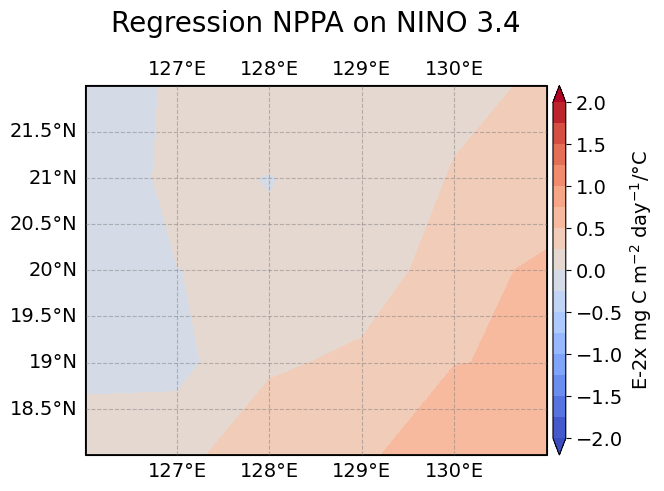

/opt/homebrew/Caskroom/miniforge/base/envs/oparcels/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/homebrew/Caskroom/miniforge/base/envs/oparcels/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


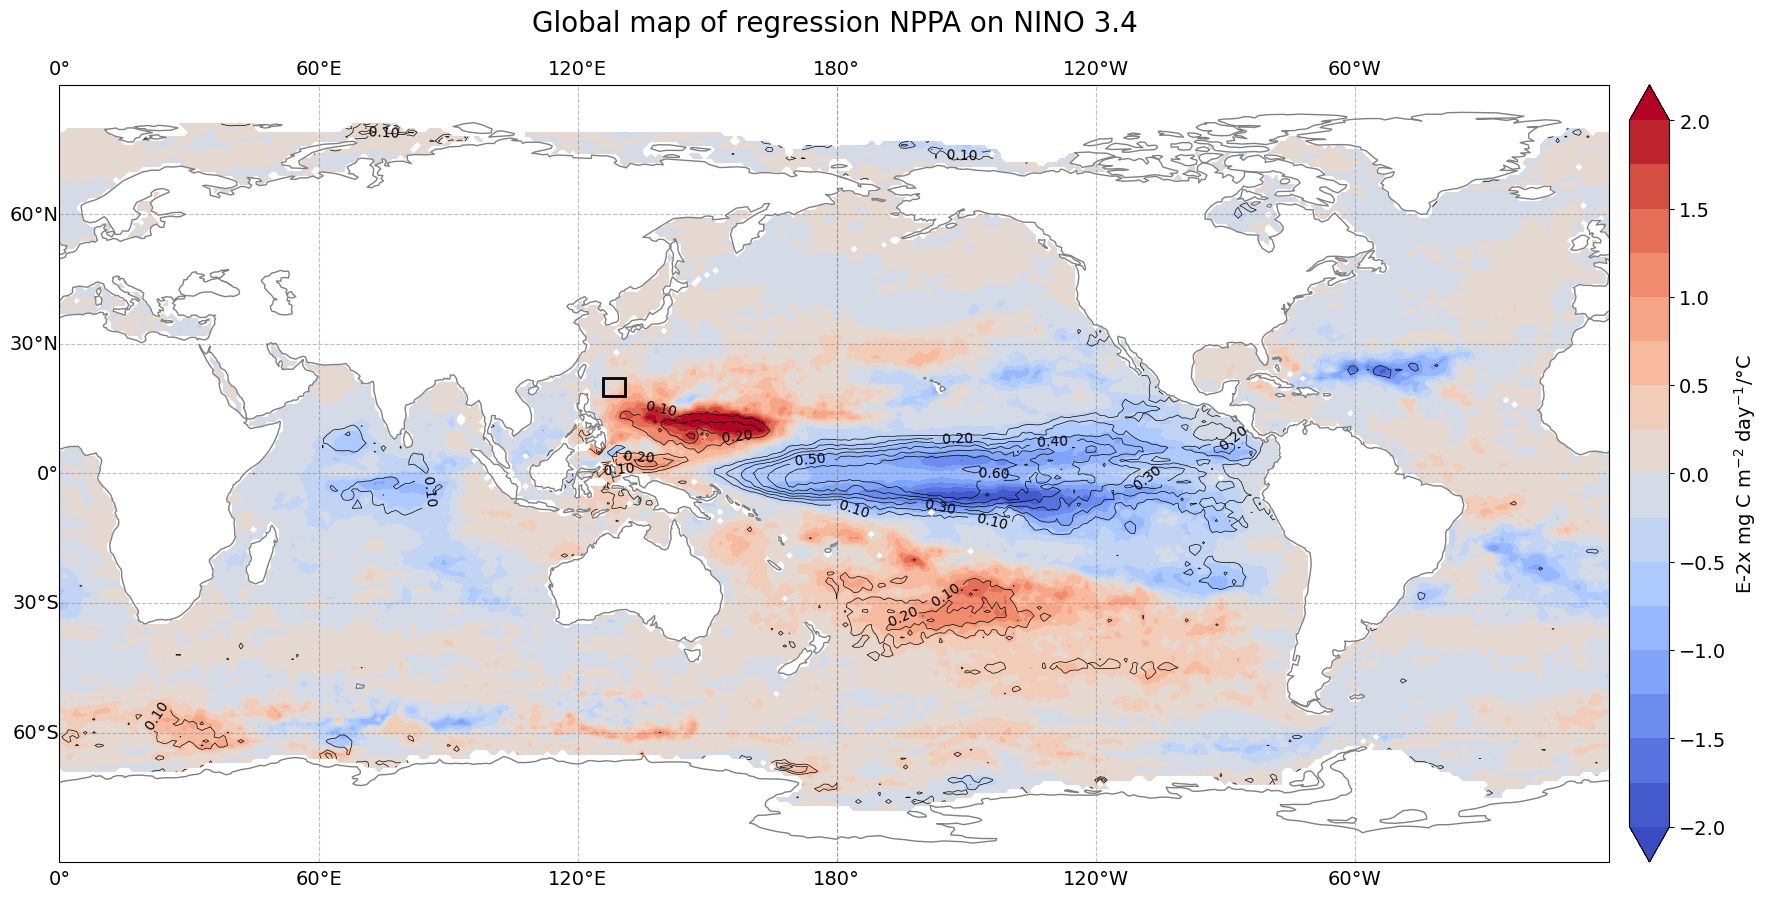

In [31]:
scale=100
# slevels, norm = getSlevels(50, step=10,scale=scale)
slevels, norm = getSlevels(0.02, step=0.0025,scale=scale)
# rslevels = np.arange(0.0, 0.9, 0.1)
rslevels = np.arange(0.0, 0.7, 0.1)

drawcontourf(reg_pairs[1][0], ss[1]*scale, rss[1], cline=True, title=titles[1], barname=f'E-2x {reg_unit}', slevels=slevels, rslevels=rslevels, norm=norm, g=True)
drawcontourf(reg_pairs[0][0], ss[0]*scale, rss[0], cline=True, title=titles[0], barname=f'E-2x {reg_unit}', figsize=(20,13), slevels=slevels, rslevels=rslevels, norm=norm, g=True)

# Power Spectral Density of NPPA and NINO3.4 index

### codes

In [ ]:
nino = xr.open_dataarray('../../Data/originals/oisstnino.nc')
npp = l_npp.interpolate_na(dim='date') #not moving average!
npp = npp.isel(lat=0, lon=0)

In [ ]:
def plotPSDs(ax, f, spec, rspec, spec95, spec99,funit ='cycle/year', xlabel = 'Frequency', ylabel = True ,xlim = False, ylim = False, xticks = False):
    if xlabel : ax.set_xlabel(f'{xlabel} ({funit})')
    if ylabel : ax.set_ylabel(f'PSD')

    ax.semilogx(f,spec, label='data', color= 'black')
    ax.semilogx(f,rspec,'-', label = 'red-noise fit', color = 'red')
    ax.semilogx(f,spec95,'--', label = '95% confidence', color = 'blue')
    ax.semilogx(f,spec99,'--', label = '99% confidence', color = 'orange')
    if xlim : ax.set_xlim(xlim)
    if ylim : ax.set_ylim(ylim)
    if xticks : ax.set_xticks(xticks)
    ax.legend(frameon = False)

def calculate_autocorr(data):
    """
    Calculate and normalize the autocorrelation of a dataset.

    Parameters:
    - data (array): The input dataset for which autocorrelation is computed.

    Returns:
    - array: Normalized autocorrelation of the input data.
    """
    autocorr = np.correlate(data, data, 'full')[len(data)-1:] #return 2n-1 length so cut middle
    autocorr = autocorr/autocorr[0] #normalize

    return autocorr

def calculate_spectrums(data, fs=1, chunks=3):
    """
    Calculate the power spectrum and red noise spectrum of a dataset along with significance levels.

    Parameters:
    - data (array): The time series data.
    - fs (float): Sampling frequency of the data. Default is 1.
                  (for example, monthly data fs is 12 samples/year, in case standard unit is year)
    - chunks (int): Number of segments to divide the data for spectral analysis. Default is 3.

    Returns:
    - tuple: Tuple containing the frequency array,power spectral density,
             red noise spectrum, 95% significance level, and 99% significance level.
    """
    T = len(data) #length of thime series
    N = chunks #number of chunks

    # compute power spectrum
    f, Pxx = signal.welch(data, window='hann', fs=fs ,nperseg=int(T/N))

    #calculate alpha and red noise
    autocorr = calculate_autocorr(data)
    alpha = autocorr[1] #lag-one autocorrelation
    h = np.arange(len(f))
    rspec = (1 - alpha**2) / (1 - 2 * alpha * np.cos(np.pi * h / len(f)) + alpha**2)

    #fit red noise to psd
    ratio = np.sum(Pxx) / np.sum(rspec)
    rspec *= ratio

    # calculate significance using F-test
    dof = 2*N*1.2 #(1.2 is additional smoothing foctor for a Hanning window)
    fstat = stats.f.ppf(.99,dof,1000)
    spec99 = [fstat*m for m in rspec]

    fstat = stats.f.ppf(.95,dof,1000)
    spec95 = [fstat*m for m in rspec]

    return f, Pxx, rspec, spec95, spec99


### excute

/var/folders/gv/5yc5yy8j1rg2ls36dbbfntr80000gn/T/ipykernel_4258/1018004599.py:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  if xlim : ax.set_xlim(xlim)
/var/folders/gv/5yc5yy8j1rg2ls36dbbfntr80000gn/T/ipykernel_4258/762615933.py:13: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[1].set_xlim((0,10))


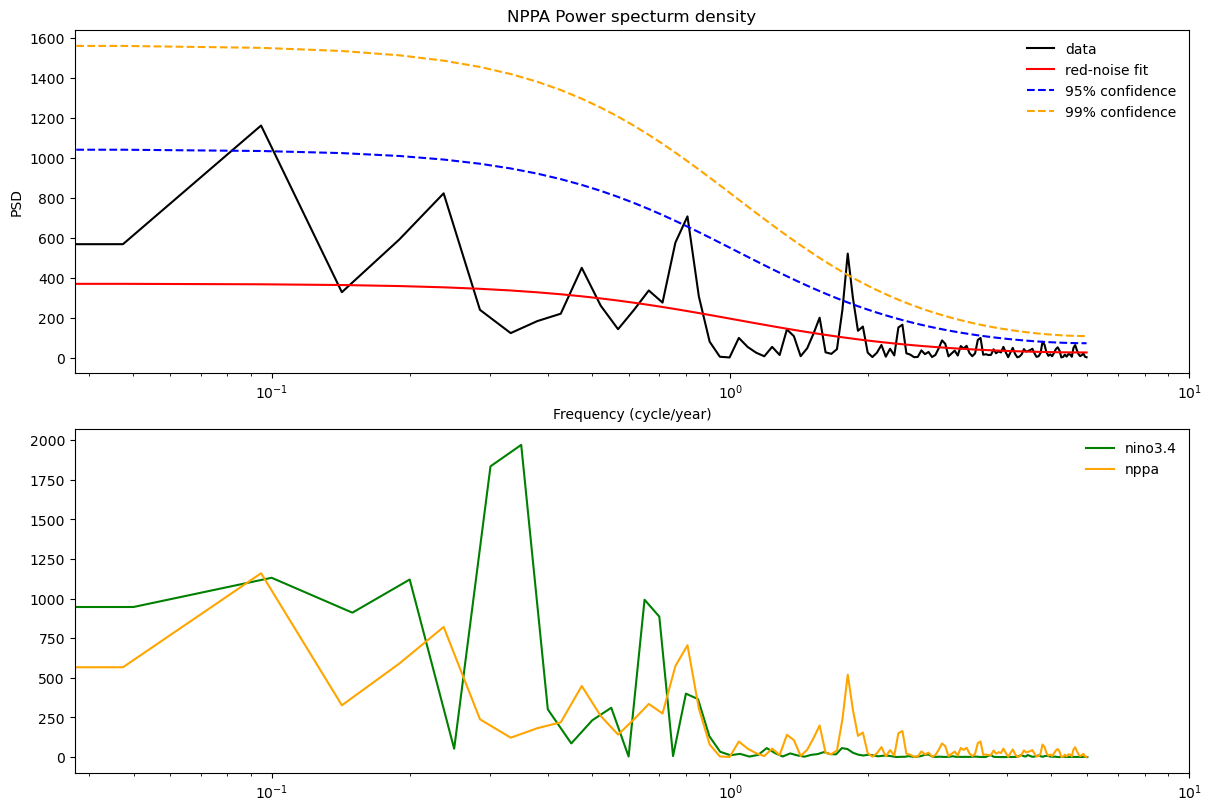

In [ ]:
f1, Pxx1, rspec1, spec951, spec991 = calculate_spectrums(nino, fs = 12, chunks=1)
f2, Pxx2, rspec2, spec952, spec992 = calculate_spectrums(npp, fs = 12, chunks=1)

fig, ax = plt.subplots(2,1, figsize=(12,8), constrained_layout=True)
ax[0].set_title('NPPA Power specturm density')
plotPSDs(ax[0], f2, Pxx2, rspec2, spec952, spec992, xlim =(0, 10))

ratio = np.sum(Pxx2) / np.sum(Pxx1)
fit_nino = ratio*Pxx1

ax[1].semilogx(f1, fit_nino, label='nino3.4', color= 'green')
ax[1].semilogx(f2,Pxx2,'-', label = 'nppa', color = 'orange')
ax[1].set_xlim((0,10))
ax[1].legend(frameon = False)